# Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
import multiprocessing as mp
import seaborn as sns
sns.set_theme(style="whitegrid")

from pprint import pprint
from matplotlib import pyplot as plt

from used_car_price.config import config
from used_car_price.processing import data_management
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from feature_engine import categorical_encoders as ce
from feature_engine import missing_data_imputers as mdi
from feature_engine import outlier_removers as remove_outlier
# from feature_engine
target = ['price']

pd.set_option("display.max_columns",None)



## Read train and test data

In [2]:
train = data_management.load_dataset(file_name=config.TRAIN_DATA_FILE)
test = data_management.load_dataset(file_name=config.TEST_DATA_FILE)

In [3]:
train.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7111829135,https://kpr.craigslist.org/ctd/d/pasco-2014-do...,kennewick-pasco-richland,https://kpr.craigslist.org,17993,2014.0,ram,1500 express rwd gas,NaN,NaN,gas,34726.0,clean,automatic,3C6JR6AT0EG257451,rwd,NaN,truck,blue,https://images.craigslist.org/00707_6geqU1Ju2e...,2014 Dodge Ram 1500 Express RWD **Clean Carfax...,NaN,wa,46.2348,-119.1280
1,7119506350,https://akroncanton.craigslist.org/ctd/d/canto...,akron / canton,https://akroncanton.craigslist.org,5999,2013.0,ford,focus,excellent,4 cylinders,gas,84381.0,clean,automatic,1FADP3F23DL162707,fwd,compact,sedan,NaN,https://images.craigslist.org/00w0w_lBVhtApnTm...,2013 *** Ford Focus 4dr Sdn SE Sedan *** Re...,NaN,oh,40.7960,-81.4315
2,7119926684,https://anchorage.craigslist.org/cto/d/talkeet...,anchorage / mat-su,https://anchorage.craigslist.org,3000,2018.0,NaN,Yamaha TTR 230,excellent,NaN,gas,NaN,clean,manual,NaN,NaN,NaN,offroad,blue,https://images.craigslist.org/00c0c_dNnBHtIY32...,"One owner, gentle used, fun bike, great condit...",NaN,ak,62.4578,-149.7040
3,7114666214,https://maine.craigslist.org/ctd/d/lewiston-20...,maine,https://maine.craigslist.org,19995,2014.0,toyota,tundra,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,https://images.craigslist.org/00k0k_aTzTKHwAjL...,"Dube's Auto Sales Lewiston, ME 207-777-3770 ...",NaN,me,44.1352,-70.1946
4,7109817548,https://cnj.craigslist.org/cto/d/belle-mead-am...,central NJ,https://cnj.craigslist.org,2500,2002.0,audi,a8l quattro,excellent,8 cylinders,gas,204000.0,salvage,automatic,WAUML44D32N001398,4wd,full-size,sedan,blue,https://images.craigslist.org/00E0E_cdnshJARL5...,Amazing Classic 2002 A8L This car has provided...,NaN,nj,40.4775,-74.6272


## Shape

In [4]:
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")

train.shape: (348679, 25)
test.shape: (87170, 25)


## Missing values

In [5]:
train_miss = round(train.isna().mean()*100,1)\
                    .sort_values(ascending=False)\
                    .to_frame(name='train_missing_percentage')\
                    .reset_index()\
                    .rename(columns={'index':'features'})

test_miss = round(test.isna().mean()*100,1)\
                    .to_frame(name='test_missing_percentage')\
                    .reset_index()\
                    .rename(columns={'index':'features'})

miss_values = train_miss.merge(test_miss, on='features')

In [6]:
miss_values

,features,train_missing_percentage,test_missing_percentage
0,county,100.0,100.0
1,size,68.0,67.7
2,vin,45.1,45.2
3,condition,42.9,42.7
4,cylinders,38.2,38.0
5,paint_color,31.1,30.9
6,drive,28.0,27.9
7,type,26.9,26.9
8,odometer,17.3,17.2
9,manufacturer,4.8,4.7


In [7]:
# Since county is entirely empty, it will be droppped
train = train.drop(columns='county')
test = test.drop(columns='county')

## Describe

In [8]:
train.describe()

,id,price,year,odometer,lat,long
count,3.486790e+05,3.486790e+05,347768.000000,2.885160e+05,342041.000000,342041.000000
mean,7.115958e+09,1.325069e+05,2009.872372,9.896209e+04,38.413437,-94.994332
std,4.592040e+06,1.621691e+07,9.304652,1.142016e+05,6.032714,18.066235
min,7.096577e+09,0.000000e+00,1900.000000,0.000000e+00,-75.760300,-177.012000
25%,7.112451e+09,4.900000e+03,2007.000000,4.742700e+04,34.226200,-111.796000
50%,7.117100e+09,9.995000e+03,2012.000000,9.117800e+04,38.949700,-89.771200
75%,7.120096e+09,1.799000e+04,2015.000000,1.347430e+05,42.484500,-81.403500
max,7.121608e+09,3.333333e+09,2021.000000,1.000000e+07,78.473300,173.675000


We can see max value of price and odometer is ridiculously highly. We will inspect them one by one.

## Target Analysis

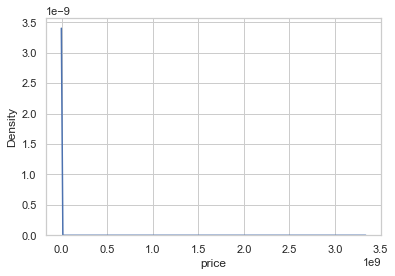

In [9]:
sns.kdeplot(data=train, x=target[0]);

Since, we can see here target is highly right skew, we need to analyze why? The quickest way is to see the make, model or 
description and see if there is something unusual with the data

In [10]:
train[train[target[0]]>1000000].head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,state,lat,long
4176,7108753879,https://yuma.craigslist.org/cto/d/somerton-198...,yuma,https://yuma.craigslist.org,11111111,1988.0,NaN,suzuki samurai,good,8 cylinders,gas,NaN,clean,automatic,NaN,4wd,NaN,offroad,black,https://images.craigslist.org/00Q0Q_7UZWnp0N9o...,Selling a 88 samari project with a 350 chevy m...,az,32.5634,-114.7130
8200,7111865892,https://westernmass.craigslist.org/cto/d/green...,western massachusetts,https://westernmass.craigslist.org,3500000,2020.0,honda,accord sport,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00O0O_a91q3PQDJF...,2020 Honda Accord Sport 1.5T for sale Messag...,ma,42.6013,-72.6236
14018,7109046695,https://evansville.craigslist.org/ctd/d/evansv...,evansville,https://evansville.craigslist.org,123456789,2005.0,jeep,wrangler,excellent,6 cylinders,gas,NaN,clean,other,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00v0v_XskwEB3yt6...,"I specialize in 2000 thru 2006 wranglers, I se...",in,38.0258,-87.5965
14460,7121060348,https://kpr.craigslist.org/cto/d/kennewick-196...,kennewick-pasco-richland,https://kpr.craigslist.org,2521176519,1964.0,volvo,544,NaN,NaN,gas,NaN,missing,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00g0g_8D26yYxQBW...,"28,354 miles on the odometer motor needs rebui...",wa,46.2109,-119.1680
19120,7117325706,https://memphis.craigslist.org/cto/d/eads-cash...,memphis,https://memphis.craigslist.org,1111111,1966.0,chevrolet,c10,NaN,NaN,gas,NaN,clean,manual,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00n0n_8CwhNDFkLv...,HAVE CASH TODAY FOR 1964-1966 CHEVROLET C10 SW...,tn,35.1551,-89.6760


In [11]:
train.loc[train['id']==7108753879, 'description'].values[0]

'Selling a 88 samari project with a 350 chevy motor has a mega 400 blower two 750 carbs,cam,rockers,valves,springs, pistons 30 over,etc.  Th 400 with shift kit,2.300 converter,manual valve body,bucket seats,9in ford diff with disc brakes Got a different project and dont have time for this one.  For info plz call or text me at  show contact info'

So, it looks like the most of the sellers post random/garbage value on the postings and this kind of spurious values will harm our analysis. In order to rectify this we will clip out the outlier using 3SD from IQR.

In [12]:
remove_outlier_price = remove_outlier.OutlierTrimmer(distribution='skewed', tail='right', fold=3)
print(f"Missing values in train target:{train[target].isna().sum()[0]}")
train['price'] = remove_outlier_price.fit_transform(train['price'].to_frame())
test['price'] = remove_outlier_price.transform(test['price'].to_frame())
print(f"Missing values in train target:{train[target].isna().sum()[0]}")


Missing values in train target:0
Missing values in train target:2696


In [13]:
# This is maximum non-spurious value comes out of outlier capping. Looks ok as there could be expensive new cars
remove_outlier_price.right_tail_caps_

{'price': 57260.0}

Null values were introduced due to dropping of dirty data

In [14]:
train = train.dropna(subset=target)
test = test.dropna(subset=target)

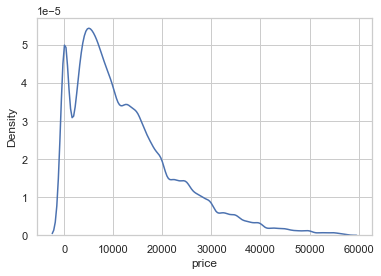

In [15]:
sns.kdeplot(data=train, x=target[0]);

So after dropping dirty data from both, since those spurious values don't represent actual vehicle

In [16]:
print(f"Minimum value in price/target: {train[target].min()[0]}")

Minimum value in price/target: 0.0


There are low values of price in our dataset and lets assume we only take data where price > 1,000. 

In [17]:
train = train[train[target[0]]>1_000].reset_index(drop=True).copy()
test = test[test[target[0]]>1_000].reset_index(drop=True).copy()

## Odometer analysis

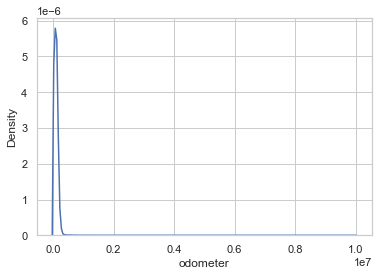

In [18]:
sns.kdeplot(data=train, x='odometer');

In [19]:
train[train['odometer']>1_000_000].head(2)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,state,lat,long
1569,7119835827,https://daytona.craigslist.org/cto/d/palm-coas...,daytona beach,https://daytona.craigslist.org,4000.0,2007.0,bmw,530i,good,6 cylinders,gas,1410000.0,clean,automatic,NaN,rwd,mid-size,sedan,silver,https://images.craigslist.org/00k0k_iaBekmtLd4...,2007 530i with 141k miles. Car runs and drives...,fl,29.5678,-81.2329
3445,7120832282,https://chico.craigslist.org/cto/d/oroville-20...,chico,https://chico.craigslist.org,6500.0,2012.0,ford,expidition,excellent,8 cylinders,gas,2000000.0,clean,automatic,NaN,NaN,NaN,NaN,black,https://images.craigslist.org/00G0G_1tbh1Z7MqP...,I have a very nice 2012 Ford Expidition for sa...,ca,39.4877,-121.4700


In [20]:
missing_data_impute_num = mdi.ArbitraryNumberImputer(arbitrary_number=-9999, variables=['odometer'])

train = missing_data_impute_num.fit_transform(train)
test = missing_data_impute_num.transform(test)


In [21]:
# all null values have been imputed by -9999
train['odometer'].isna().sum()

0

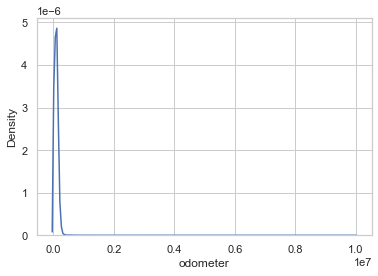

In [22]:
# Plot before outlier removal
sns.kdeplot(data=train, x= 'odometer');

In [23]:
remove_outlier_odometer = remove_outlier.OutlierTrimmer(distribution='skewed', tail='right', fold=3)

train['odometer'] = remove_outlier_odometer.fit_transform(train['odometer'].to_frame())
test['odometer'] = remove_outlier_odometer.transform(test['odometer'].to_frame())


train = train.dropna(subset=['odometer']).reset_index(drop=True)
test = test.dropna(subset=['odometer']).reset_index(drop=True)

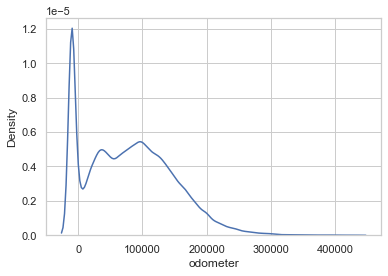

In [24]:
# PLot after outlier removal
sns.kdeplot(data=train, x= 'odometer');

In [25]:
print(f"train.shape:{train.shape}")
print(f"test.shape:{test.shape}")

train.shape:(309860, 24)
test.shape:(77413, 24)


## Check for duplicate ID

In [26]:
print(f"Train shape:{train.shape}")
print(f"Test shape:{test.shape}")

print(f"Number of duplicates in train: {len(train[train.duplicated()])}")
print(f"Number of duplicates in test: {len(test[test.duplicated()])}")

print(f"Unique id in train:{train['id'].nunique()}")
print(f"Unique id in test:{test['id'].nunique()}")

Train shape:(309860, 24)
Test shape:(77413, 24)
Number of duplicates in train: 0
Number of duplicates in test: 0
Unique id in train:309860
Unique id in test:77413


1. Since number of id is equal to number of observations it can be dropped.
2. We will drop url, region_url, image_url, lat, long, description(could be helpful to draw more insights) for now 

In [27]:
cols_to_drop = ['id', 'url', 'region_url', 'image_url', 'lat', 'long', 'description', 'region']

train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [28]:
print(f"Train shape before dup:{train.shape}")
print(f"Test shape before dup:{test.shape}")


print(f"Number of duplicates in train: {len(train[train.duplicated()])}")
print(f"Number of duplicates in test: {len(test[test.duplicated()])}")

# This duplicates arises because some vehicles were listed multiple times so they have multiple id's in the data. 
# Once we drop the id, all listing corresponding to a VIN becomes duplicate and therefore needs to be dropped. 
# Example VIN: WA1LAAF78HD040006

# Drop duplicate observations
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

print(f"Train shape after dedup:{train.shape}")
print(f"Test shape after dedup:{test.shape}")

Train shape before dup:(309860, 16)
Test shape before dup:(77413, 16)
Number of duplicates in train: 55130
Number of duplicates in test: 5100
Train shape after dedup:(254730, 16)
Test shape after dedup:(72313, 16)


## Correlation

In [29]:
train.corr()['price'].to_frame()

,price
price,1.000000
year,0.300265
odometer,-0.282554


1. Positive correlation value of year makes sense as high value of year corresponds to higher price
2. Negative correlation value of odometer makes sense as higher value of odometer/mileage corresponds to lower price

## Extract categorical and numerical features

In [30]:
categorical_cols = train.select_dtypes(include='object').columns.tolist()
numerical_cols = train.select_dtypes(exclude='object').columns.tolist()

In [31]:
print(f"Categorical columns: {categorical_cols}\n")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'state']

Numerical columns: ['price', 'year', 'odometer']


In [32]:
train['vin'].value_counts()

NM0GE9E73G1278693    23
JM1NDAM74H0106020    23
5TDKZ3DC9KS018078    21
1FTFW1ET2EFA54776    20
00000000000000000    19
                     ..
LRBFXFSX0HD024479     1
3KPFK4A78JE164712     1
1FMCU9G96JUC65070     1
1FMCU9GX6EUA53158     1
ZFBCFAAH5EZ012639     1
Name: vin, Length: 107463, dtype: int64

In [33]:
train[train['vin']=='NM0GE9E73G1278693']

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state
9853,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,vt
23232,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,ny
26072,26500.0,2016.0,NaN,Mini-t Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,va
31201,26500.0,2016.0,NaN,Mini-T Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,NaN,NaN,van,NaN,wa
31547,26500.0,2016.0,NaN,Mini-T Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,tx
50442,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,md
88044,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,mi
104090,26500.0,2016.0,NaN,Mini-T Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,NaN,NaN,van,NaN,il
111557,26500.0,2016.0,NaN,Transit Connect CamperVan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,oh
119746,26500.0,2016.0,mini,campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,ia


We can see here duplicate vin corresponds to duplicate listings to increase the probability of selling the vehicle. For training, it is not a good idea to keep duplicate vins so we will keep one of all duplicate records. We can keep the duplicate in test data since duplicate affects the training not prediction.

In [34]:
train = train.drop_duplicates(subset=['vin'], keep='first').reset_index(drop=True)

## Lets evaluate vin & cylinders

In [35]:
train.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state
0,17993.0,2014.0,ram,1500 express rwd gas,NaN,NaN,gas,34726.0,clean,automatic,3C6JR6AT0EG257451,rwd,NaN,truck,blue,wa
1,5999.0,2013.0,ford,focus,excellent,4 cylinders,gas,84381.0,clean,automatic,1FADP3F23DL162707,fwd,compact,sedan,NaN,oh
2,3000.0,2018.0,NaN,Yamaha TTR 230,excellent,NaN,gas,-9999.0,clean,manual,NaN,NaN,NaN,offroad,blue,ak
3,2500.0,2002.0,audi,a8l quattro,excellent,8 cylinders,gas,204000.0,salvage,automatic,WAUML44D32N001398,4wd,full-size,sedan,blue,nj
4,7995.0,2009.0,honda,accord,NaN,4 cylinders,gas,117630.0,clean,automatic,1HGCP26879A071691,fwd,NaN,sedan,grey,oh


In [36]:
class Preprocessing(BaseEstimator, TransformerMixin):
    """
    Simple transformer to indicate if vin is present or not. If present then 1 else 0
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X['vin'].isna(), 'vin']=0
        X.loc[~X['vin'].isna(), 'vin']=1
#         X['cylinders'] = X['cylinders'].str.replace('cylinders','')
#         X.loc[X['cylinders']=='other', 'cylinders'] = '99'
        X['vin'] = X['vin'].astype('int')
        return X

In [37]:
ppr  = Preprocessing()

train = ppr.fit_transform(train)
test = ppr.transform(test)

## Box Plot

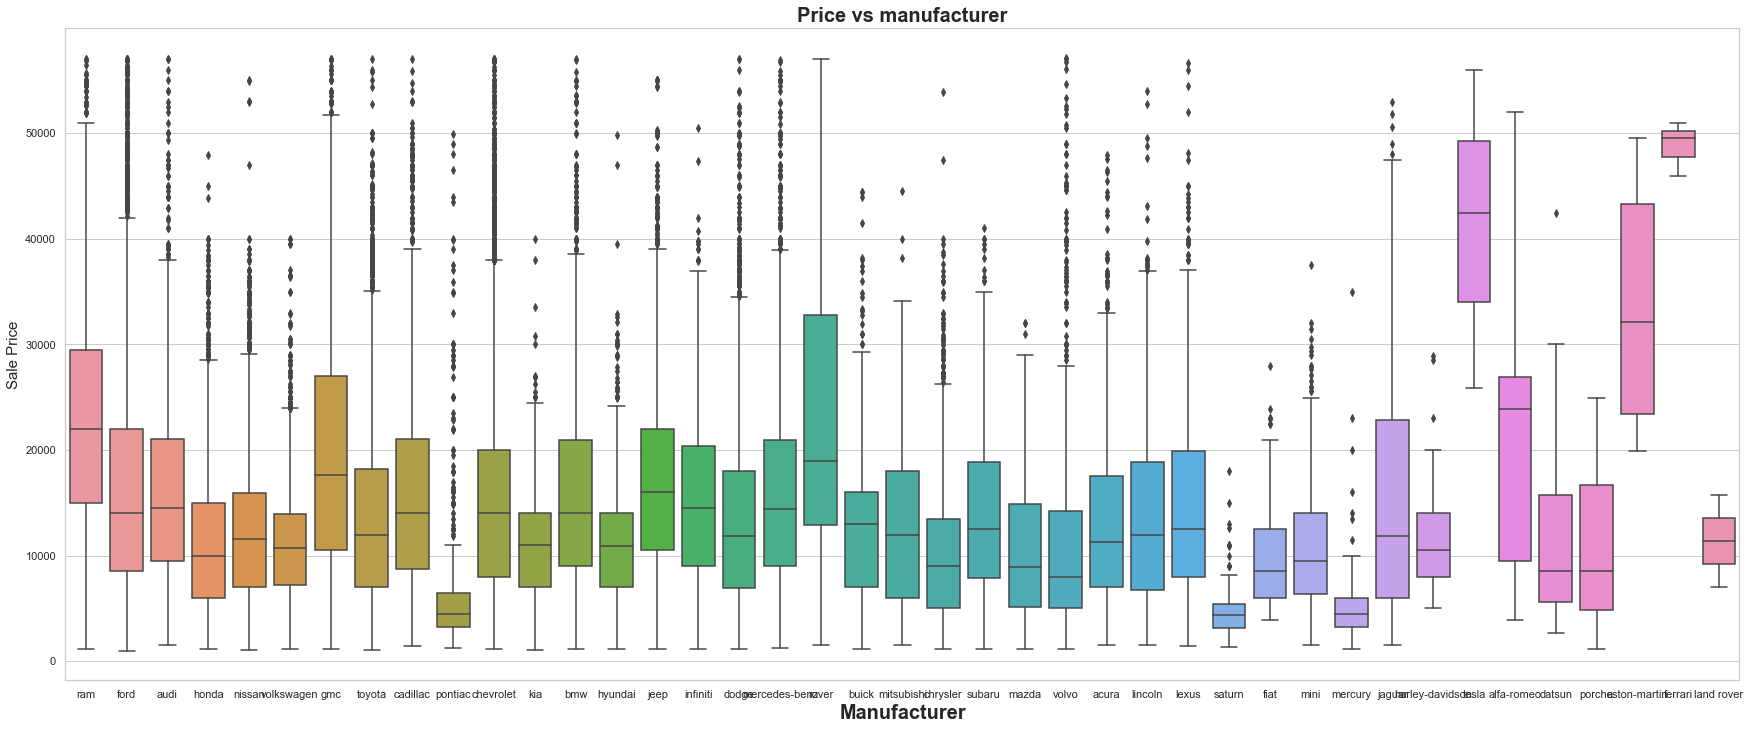

In [38]:
plt.figure(figsize=(30,12))
sns.boxplot(y=target[0], x='manufacturer', data= train)
plt.title("Price vs manufacturer", fontsize=20,fontweight='bold')
plt.xlabel("Manufacturer", fontsize=20,fontweight='bold')
plt.ylabel("Sale Price", fontsize=15)
plt.show()

## Pair plot

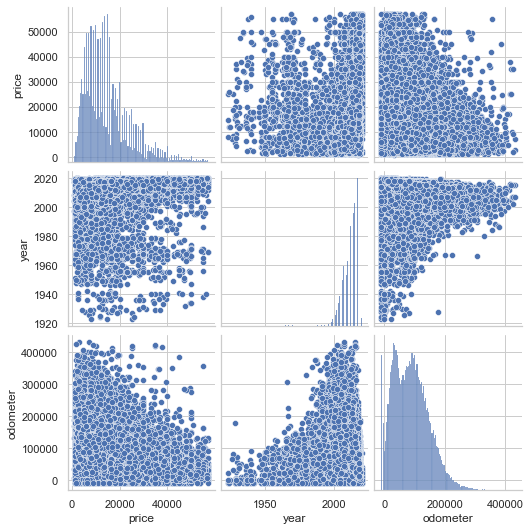

In [39]:
sns.pairplot(data=train[numerical_cols]);

## Regresion plot

In [40]:
numerical_cols

['price', 'year', 'odometer']

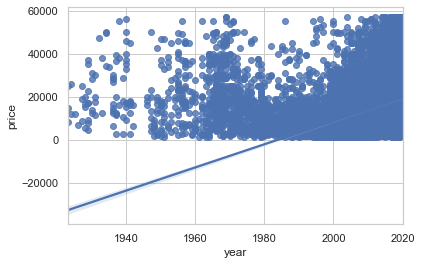

In [41]:
sns.regplot(x=train["year"], y=train["price"], scatter= True, fit_reg= True);

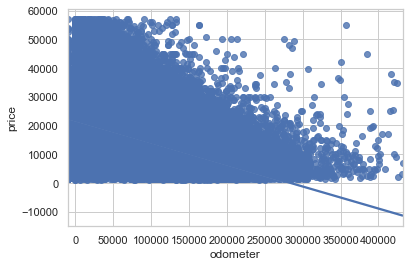

In [42]:
sns.regplot(x=train["odometer"], y=train["price"], scatter= True, fit_reg= True);

## Scatter plot

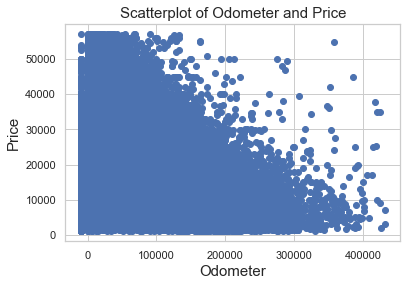

In [43]:
plt.title("Scatterplot of Odometer and Price", fontsize=15)
plt.xlabel("Odometer", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.scatter(x= train.odometer, y= train.price);

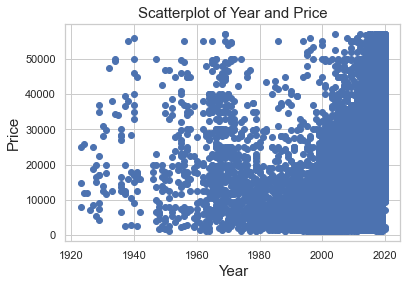

In [44]:
plt.title("Scatterplot of Year and Price", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.scatter(x= train.year, y= train.price);

## Categorical variables plot

In [45]:
categorical_cols

['manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'vin',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

# Count plot

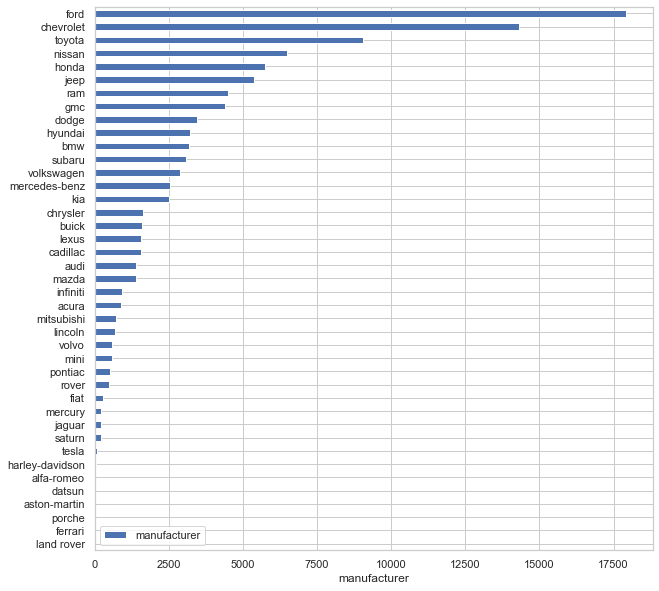

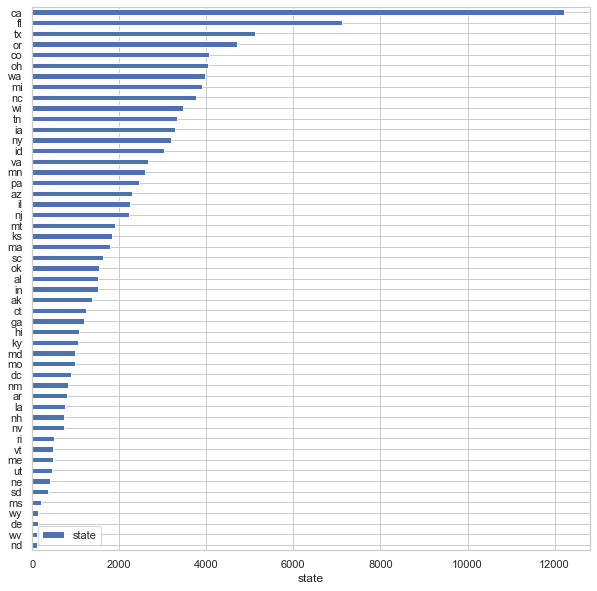

In [46]:
for col in ['manufacturer', 'state']:
    train[col].value_counts().sort_values().to_frame().plot(kind='barh', figsize=(10,10))
    plt.xlabel(f"{col}")

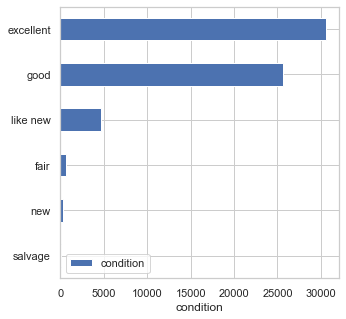

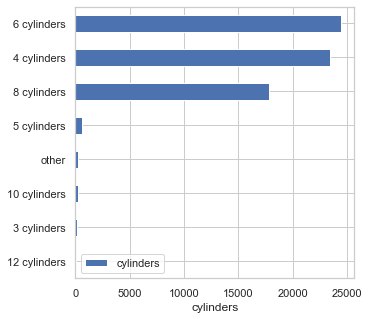

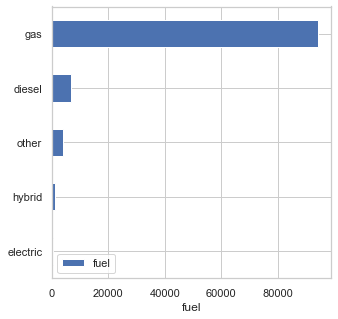

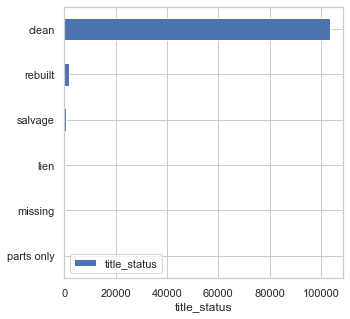

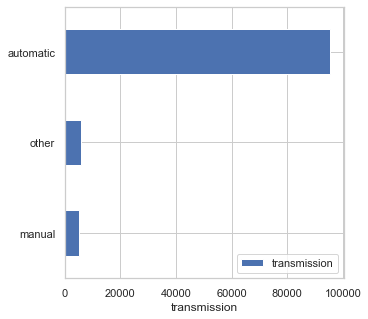

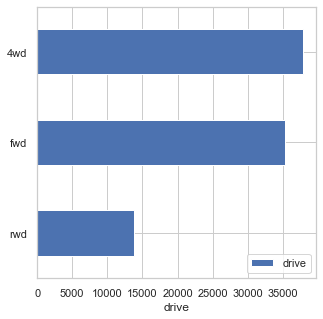

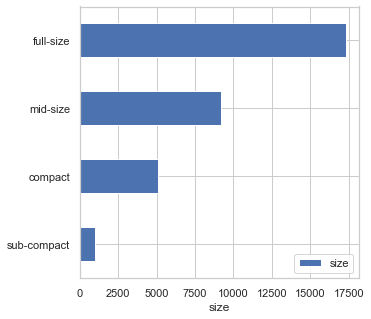

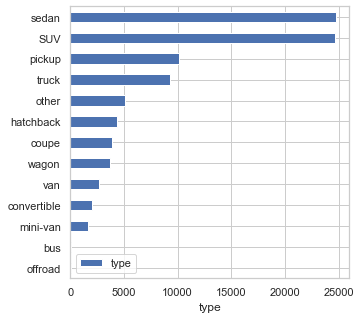

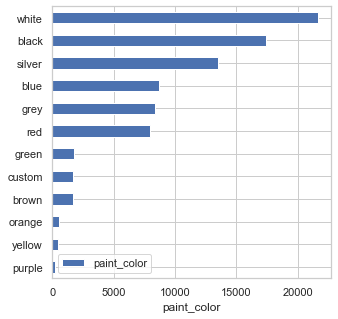

In [47]:
for col in categorical_cols:
    if col not in ['manufacturer', 'model', 'vin', 'state']:
        train[col].value_counts().sort_values().to_frame().plot(kind='barh', figsize=(5,5))
        plt.xlabel(f'{col}')
        plt.show()

In [48]:
train['model'].nunique()

15238

No plot for model because it has 15,238 values and it will consume a lot of space and time to generate plot

## Impute missing values

In [108]:
# Impute numerical columns
missing_data_impute_num = mdi.ArbitraryNumberImputer(arbitrary_number=-9999, variables=['year','odometer'])
train_ = missing_data_impute_num.fit_transform(train_)
test_ = missing_data_impute_num.transform(test_)

In [109]:
# Impute categorical columns
missing_data_impute_cat = mdi.CategoricalVariableImputer(imputation_method='missing', fill_value='missing')
train_ = missing_data_impute_cat.fit_transform(train_)
test_ = missing_data_impute_cat.transform(test_)

In [110]:
rl1=ce.RareLabelCategoricalEncoder(tol=0.01, variables=['manufacturer'], n_categories=5, replace_with='rare')

rl2 = ce.RareLabelCategoricalEncoder(tol=0.01, variables=['cylinders'], n_categories=5,replace_with='-1')

rl3 = ce.RareLabelCategoricalEncoder(tol=0.07, variables=['condition'], replace_with='rare', n_categories=3)

rl4 = ce.RareLabelCategoricalEncoder(tol=0.04, variables=['type'], replace_with='rare', n_categories=3)

rl5 = ce.RareLabelCategoricalEncoder(tol=0.05, variables=['paint_color'], replace_with='rare',n_categories=3)

rl6 = ce.RareLabelCategoricalEncoder(tol=0.05, variables=['transmission'], replace_with='rare', n_categories=3)

In [111]:
pipeline_ =[]

pipeline_.append(('rl1', rl1))
pipeline_.append(('rl2', rl2))
pipeline_.append(('rl3', rl3))
pipeline_.append(('rl4', rl4))
pipeline_.append(('rl5', rl5))
pipeline_.append(('rl6', rl6))

In [112]:
transform_pipeline = Pipeline(pipeline_)

In [113]:
cols_to_drop_2 = ['model']
train_ = train_.drop(columns=cols_to_drop_2)
test_ = test_.drop(columns=cols_to_drop_2)

train_ = transform_pipeline.fit_transform(train_)
test_ = transform_pipeline.transform(test_)

In [114]:
# cat_encode = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency')
# train_ = cat_encode.fit_transform(train_)
# test_ = cat_encode.transform(test_)

In [122]:
features = [feat for feat in train_.columns if feat not in target]

mee_encode = MEstimateEncoder(random_state=config.RANDOM_STATE, m=50)
train_mee = mee_encode.fit_transform(X=train_[features], y=train_[target])
test_ = mee_encode.transform(test_[features])

c:\users\steja\anaconda3\envs\used_car_price\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
features

In [123]:
features = [feat for feat in train_.columns if feat not in target]
features

['year',
 'manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'vin',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [124]:
train_[features].head()

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state
0,2014.0,ram,missing,missing,gas,34726.0,clean,automatic,1,rwd,missing,truck,blue,wa
1,2013.0,ford,excellent,4 cylinders,gas,84381.0,clean,automatic,1,fwd,compact,sedan,missing,oh
2,2018.0,missing,excellent,missing,gas,-9999.0,clean,rare,1,missing,missing,rare,blue,ak
3,2002.0,audi,excellent,8 cylinders,gas,204000.0,salvage,automatic,1,4wd,full-size,sedan,blue,nj
4,2009.0,honda,missing,4 cylinders,gas,117630.0,clean,automatic,1,fwd,missing,sedan,grey,oh


In [125]:
# lr = LinearRegression()
# lr.fit(train_[features], train_[target])
# prediction = lr.predict(train_[features])
# train_['predictions'] = prediction

In [126]:
# sns.distplot(x=train_[target])

In [127]:
scores = cross_validate(estimator=XGBRegressor(), 
                        X=train_mee, 
                        y=train_[target].values.ravel(), 
                        cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True,
                        return_estimator=True)

In [128]:
print(round(scores['train_r2'].mean()*100,1))
print(round(scores['test_r2'].mean()*100,1))

68.0
61.1


In [ ]:
round(scores['train_r2'].mean()*100,1)

In [130]:
scores['estimator']

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,

In [ ]:
round(scores['test_r2'].mean()*100,1)

In [ ]:
np.mean([np.sqrt(-(score)) for score in scores['train_neg_mean_squared_error']])

In [ ]:
np.mean([np.sqrt(-(score)) for score in scores['test_neg_mean_squared_error']])

In [ ]:
# test_ = model_pipeline.transform(test[features])
X=train_[features]
y=train_[target]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_prediction = np.zeros(X.shape[0])
oof_prediction = np.zeros(X.shape[0])
sub_prediction = np.zeros(test_.shape[0])
folds_score = []
params_dict = {"objective": "reg:squarederror",
          "eta": 0.3,
          "max_depth": 30,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "seed":42}

for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

    dtrain = xgb.DMatrix(data=X_train.values, label=y_train.values)
    dvalid = xgb.DMatrix(data=X_valid.values, label=y_valid.values)

    clf = xgb.train(params=params_dict, dtrain=dtrain,
                    evals=[(dtrain, "Train"), (dvalid, "Val")],
                    early_stopping_rounds=50,
                    verbose_eval=0,
                    )

    train_prediction[train_index] = clf.predict(xgb.DMatrix(X_train.values), ntree_limit=clf.best_iteration)
    oof_prediction[valid_index] = clf.predict(xgb.DMatrix(X_valid.values), ntree_limit=clf.best_iteration)
    sub_prediction += clf.predict(xgb.DMatrix(test_[features].values), ntree_limit=clf.best_iteration) / kf.get_n_splits()
    
    # Winzorization
    train_prediction[train_index] = np.clip(a=train_prediction[train_index], a_min=0, a_max=None)
    oof_prediction[valid_index] = np.clip(a=oof_prediction[valid_index], a_min=0, a_max=None)
    sub_prediction = np.clip(a=sub_prediction, a_min=0, a_max=None)
    
    
    train_r2 = round(r2_score(y_pred=train_prediction[train_index],y_true=y_train)*100,1)
    validation_r2 = round(r2_score(y_pred=oof_prediction[valid_index],y_true=y_valid)*100,1)
    print(f"FOLD: {fold+1}: train r2: {train_r2}, valid r2: {validation_r2}")
    folds_score.append(validation_r2)

print()
print(f"Mean Validation score: {sum(folds_score)/kf.get_n_splits()}")
print(f"Validation data r2: {round(r2_score(y_pred=oof_prediction,y_true=train[target])*100,1)}")
print(f"Test data r2: {round(r2_score(y_pred=sub_prediction,y_true=test[target])*100,1)}")
print(f"Test data MAE: {round(mean_absolute_error(y_pred=sub_prediction,y_true=test[target])*100,1)}")
print(f"Test data RMSE: {round(np.sqrt(mean_squared_error(y_pred=sub_prediction,y_true=test[target])*100))}")


In [ ]:
test_.isna().sum()

In [ ]:
categorical_cols = train.select_dtypes(include='object').columns.tolist()
numerical_cols = train.select_dtypes(exclude='object').columns.tolist()

In [ ]:
train.shape

# Let's evaluate size

In [ ]:
categorical_cols, numerical_cols

In [ ]:
round(train['size'].isna().mean()*100, 1)

In [ ]:
# plt.figsize(10,10)
ax = train['size'].value_counts().plot.bar()
# plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() , p.get_height()))


In [ ]:
train['size'].fillna('missing').value_counts().plot.bar()

## Let's evaluate condition

In [ ]:
round(train['condition'].isna().mean()*100, 1)

In [ ]:
ax = round(train['condition'].value_counts(normalize=True)*100,2).plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() , p.get_height()))

In [ ]:
ax = round(train['condition'].fillna('missing').value_counts(normalize=True)*100,2).plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() , p.get_height()))

In [ ]:
miss_impute_condition = mdi.CategoricalVariableImputer(imputation_method='missing', 
                                                       fill_value='missing', 
                                                       variables=['condition'] )

train['condition'] = miss_impute_condition.fit_transform(train[['condition']])
test['condition'] = miss_impute_condition.transform(test[['condition']])

In [ ]:
fig_size = (15,15)
#  subplot #1
plt.subplot(321)
plt.title('box plot of train price')
train['price'].plot.box(figsize=fig_size);

#  subplot #2
plt.subplot(322)
plt.title('box plot of test price')
test['price'].plot.box(figsize=fig_size);

plt.subplot(323)
plt.title('box plot of train price II')
train.loc[train['price']<100_000, 'price'].plot.box(figsize=fig_size);

plt.subplot(324)
plt.title('box plot of test price II')
test.loc[test['price']<100_000, 'price'].plot.box(figsize=fig_size);

# plt.subplot(325)
# plt.title('box plot of train price III')
# train.loc[train['price']<60_000, 'price'].plot.box(figsize=fig_size);

# plt.subplot(326)
# plt.title('box plot of test price III')
# test.loc[test['price']<60_000, 'price'].plot.box(figsize=fig_size);

plt.show()

In [ ]:
remove_outlier_price = remove_outlier.OutlierTrimmer(distribution='skewed', tail='right', fold=4)
train['price'] = remove_outlier_price.fit_transform(train['price'].to_frame())
test['price'] = remove_outlier_price.transform(test['price'].to_frame())

In [ ]:
sns.boxplot(x=train['price']);

In [ ]:
train = train[train['price']<60_000].copy()
test = test[test['price']<60_000].copy()

First step is to check if there are any duplicate observations in train and test data. If there are any duplicates we need to drop them.

# Percentage of missing values in each column

In [ ]:
round(test.isna().mean().sort_values()*100,1)

Since county is 100% empty, it can be dropped

# Correlation

In [ ]:
train.corr()

# Info

In [ ]:
train.info()

# Describe

In [ ]:
train.describe()

We can see that 75 percentile value for price is 18_900 and max is 100_000 which implies target(price) is right skew and same goes for odometer. Below hist also shows that

In [ ]:
#  subplot #1
plt.subplot(221)
plt.title('hist of train price')
train['price'].plot.hist(figsize=(15,8));

#  subplot #2
plt.subplot(222)
plt.title('hist of test price')
test['price'].plot.hist(figsize=(15,8));

plt.subplot(223)
plt.title('hist of train odometer')
test['odometer'].plot.hist(figsize=(15,8));

plt.subplot(224)
plt.title('hist of test odometer')
test['odometer'].plot.hist(figsize=(15,8));

plt.show()



We can also see that odometer has outliers/dirty data since it's very rare to have odometer value as high in plot. We will need to trim/cap the values.

In [ ]:
ot = remove_outlier.OutlierTrimmer(distribution='skewed', tail='right', fold=3)

In [ ]:
train = train.query("odometer>100")
test = test.query("odometer!=0")

In [ ]:
train[train['odometer']==0]

In [ ]:
ot.fit_transform(train['odometer'])

In [ ]:
mdi.MeanMedianImputer

In [ ]:
mdi_odometer = mdi.MeanMedianImputer(imputation_method='median', variables=['odometer'])
train['odometer'] = mdi_odometer.fit_transform(train[['odometer']])
test['odometer'] = mdi_odometer.transform(test[['odometer']])

remove_outlier_odometer = remove_outlier.OutlierTrimmer(distribution='skewed', 
                                                        tail='right', 
                                                        fold=3, 
                                                        variables=['odometer'])

train['odometer'] = remove_outlier_odometer.fit_transform(train['odometer'].to_frame())
test['odometer'] = remove_outlier_odometer.transform(test['odometer'].to_frame())

In [ ]:
train['odometer'].plot.box()

In [ ]:
train.sort_values(['odometer'], ascending=True)

In [ ]:
sns.displot(x=train.loc[train['odometer']<500_000, 'odometer']);

In [ ]:
fig_size = (15,15)
#  subplot #1
plt.subplot(221)
plt.title('box plot of train price')
train['odometer'].plot.box(figsize=fig_size);

#  subplot #2
plt.subplot(222)
plt.title('box plot of test price')
test['odometer'].plot.box(figsize=fig_size);


#  subplot #1
plt.subplot(223)
plt.title('box plot of train price')
train['odometer'].plot.box(figsize=fig_size);

#  subplot #2
plt.subplot(224)
plt.title('box plot of test price')
test['odometer'].plot.box(figsize=fig_size);

# Boxplot of numerical data

In [ ]:
categorical_col = train.select_dtypes(include='object').columns.tolist()
numerical_col  = train.select_dtypes(exclude='object').columns.tolist()
print(f"categorical cols: {categorical_col}\n")
print(f"numerical cols: {numerical_col}")

In [ ]:
for col, index in zip(numerical_col, [1,3,5]):
#     plt.figure(figsize=(15,8))#figsize=(15,8)
    plt.subplot(3,2,index)
    sns.boxplot(x=train[col])
    
#     plt.figure(figsize=(15,8))
    plt.subplot(3,2,index+1)
    sns.violinplot(x=train[col])
    plt.show()
    
# plt.title('hist of train price')
# train['price'].plot.hist(figsize=(15,8));

# #  subplot #2
# plt.subplot(222)
# plt.title('hist of test price')
# test['price'].plot.hist(figsize=(15,8));

# plt.subplot(223)
# plt.title('hist of train odometer')
# test['odometer'].plot.hist(figsize=(15,8));

# plt.subplot(224)
# plt.title('hist of test odometer')
# test['odometer'].plot.hist(figsize=(15,8));

# plt.show()

In [ ]:
train.head()

 # Unique

In [ ]:
train.nunique().sort_values()

In [ ]:
test.nunique().sort_values()

# Object columns

In [ ]:
train.dtypes

In [ ]:
# There are lots of categorical variable. We need to deal with them carefully.
train.select_dtypes(include='object').columns.tolist()

In [ ]:
train.select_dtypes(exclude='object').columns.tolist()

In [ ]:
train.head()

Let's start with transmission because it has lowest number of unique values

In [ ]:
round(train['transmission'].value_counts(normalize=True)*100, 1)

In [ ]:
round(train['title_status'].value_counts(normalize=True)*100, 1)

In [ ]:
round(train['region'].value_counts(normalize=True)*100,1)

Since title status has 94.6% value as clean at the first attempt we will try to drop it and later possibly combine with rare label encoder or something else. So for now we will drop it. 

In [ ]:
train = train.drop(columns=['title_status', 'region', 'model'])
test = test.drop(columns=['title_status', 'region', 'model'])

# Missing values

In [ ]:
numerical_col

In [ ]:
train['year'].isna().mean()

In [ ]:
# For transmission if we combine manual and other there should not be 

In [ ]:
class Preprocessing(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X['vin'].isna(), 'vin']=0
        X.loc[~X['vin'].isna(), 'vin']=1
        X['vin'] = X['vin'].astype('int')
        X['cylinders'] = X['cylinders'].str.replace('cylinders','')
        return X
    
class ChangeColType(TransformerMixin):
    def __init__(self, col, col_type):
        self.col = col
        self.col_type = col_type
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.col] = X[self.col].astype(self.col_type)
        return X
    
    
pipe = []
pipe.append(('preprocessing',Preprocessing()))

pipe.append(('random_num',mdi.ArbitraryNumberImputer(arbitrary_number=-9999, variables=['year','odometer'])))
pipe.append(('cyl_impute', mdi.CategoricalVariableImputer(imputation_method='missing', fill_value='-1', variables=['cylinders'])))
pipe.append(('cat_impute', mdi.CategoricalVariableImputer(imputation_method='missing', fill_value='missing')))



pipe.append(('rare_label_1',ce.RareLabelCategoricalEncoder(tol=0.01, 
                                                                        variables=['manufacturer'], 
                                                                        n_categories=5,
                                                                        replace_with='rare')))

pipe.append(('rare_label_2',ce.RareLabelCategoricalEncoder(tol=0.01, 
                                                                        variables=['cylinders'], 
                                                                        n_categories=5,
                                                                        replace_with='-1')))

pipe.append(('rare_label_3',ce.RareLabelCategoricalEncoder(tol=0.07, variables=['condition'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('rare_label_4',ce.RareLabelCategoricalEncoder(tol=0.04, variables=['type'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('rare_label_5',ce.RareLabelCategoricalEncoder(tol=0.05, variables=['paint_color'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('rare_label_6',ce.RareLabelCategoricalEncoder(tol=0.05, variables=['transmission'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('cat_encode',ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables=['manufacturer',
                                                                                                      'condition', 'fuel',
                                                                                                                   'transmission','drive',
                                                                                                                   'size','type',
                                                                                                                   'paint_color',
                                                                                                                   'state'])))

pipe.append(('change_year_type',ChangeColType(col='year', col_type='int')))
pipe.append(('change_cylinders_type',ChangeColType(col='cylinders', col_type='int')))

model_pipeline = Pipeline(pipe)
features = set(train.columns).difference(target)

X = model_pipeline.fit_transform(train[features])
y = train[target].copy()

In [ ]:
# pd.set_option("display.max_rows", None)
# train['model'].value_counts()

In [ ]:
X.head()

In [ ]:
train.head()

In [ ]:

# train = train[(train['price']>=1_000) & (train['price']<=100_000)].reset_index(drop=True).copy()

# cat_columns = ['manufacturer','model','condition','fuel','transmission','drive','size','type','paint_color','state']





test_ = model_pipeline.transform(test[features])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_prediction = np.zeros(X.shape[0])
oof_prediction = np.zeros(X.shape[0])
sub_prediction = np.zeros(test_.shape[0])
folds_score = []
params_dict = {"objective": "reg:squarederror",
          "eta": 0.3,
          "max_depth": 30,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "seed":42}

for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

    dtrain = xgb.DMatrix(data=X_train.values, label=y_train.values)
    dvalid = xgb.DMatrix(data=X_valid.values, label=y_valid.values)

    clf = xgb.train(params=params_dict, dtrain=dtrain,
                    evals=[(dtrain, "Train"), (dvalid, "Val")],
                    early_stopping_rounds=50,
                    verbose_eval=0,
                    )

    train_prediction[train_index] = clf.predict(xgb.DMatrix(X_train.values), ntree_limit=clf.best_iteration)
    oof_prediction[valid_index] = clf.predict(xgb.DMatrix(X_valid.values), ntree_limit=clf.best_iteration)
    sub_prediction += clf.predict(xgb.DMatrix(test_.values), ntree_limit=clf.best_iteration) / kf.get_n_splits()
    
    # Winzorization
    train_prediction[train_index] = np.clip(a=train_prediction[train_index], a_min=0, a_max=None)
    oof_prediction[valid_index] = np.clip(a=oof_prediction[valid_index], a_min=0, a_max=None)
    sub_prediction = np.clip(a=sub_prediction, a_min=0, a_max=None)
    
    
    train_r2 = round(r2_score(y_pred=train_prediction[train_index],y_true=y_train)*100,1)
    validation_r2 = round(r2_score(y_pred=oof_prediction[valid_index],y_true=y_valid)*100,1)
    print(f"FOLD: {fold+1}: train r2: {train_r2}, valid r2: {validation_r2}")
    folds_score.append(validation_r2)

print()
print(f"Mean Validation score: {sum(folds_score)/kf.get_n_splits()}")
print(f"Validation data r2: {round(r2_score(y_pred=oof_prediction,y_true=train[target])*100,1)}")
print(f"Test data r2: {round(r2_score(y_pred=sub_prediction,y_true=test[target])*100,1)}")
print(f"Test data MAE: {round(mean_absolute_error(y_pred=sub_prediction,y_true=test[target])*100,1)}")
print(f"Test data RMSE: {round(np.sqrt(mean_squared_error(y_pred=sub_prediction,y_true=test[target])*100))}")


In [ ]:
test['predictions'] = sub_prediction


In [ ]:
test.head()

In [ ]:
train.shape

In [ ]:
X['predicted'] = np.round(train_prediction).astype('int')

In [ ]:
train.head()

In [ ]:
train['residual'] = train['price']-train['predicted']

In [ ]:
train.sort_values(['residual'], ascending=False).head()

In [ ]:
train['price'].plot.hist()

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
#
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
from usedcarprice.config import config
from usedcarprice import pipeline

def train_model():

    train = pd.read_csv(config.TRAIN_DATA)
    test = pd.read_csv(config.TEST_DATA)

    features = config.FEATURES
    target = config.TARGET

    X = pipeline.model_pipeline.fit_transform(train[features])
    y = train[target].copy()
    test_ = pipeline.model_pipeline.transform(test[features])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    train_prediction = np.zeros(X.shape[0])
    oof_prediction = np.zeros(X.shape[0])
    sub_prediction = np.zeros(test_.shape[0])
    folds_score = []
    params_dict = {"objective": "reg:squarederror",
                   "eta": 0.3,
                   "max_depth": 30,
                   "subsample": 0.7,
                   "colsample_bytree": 0.7
                   }

    for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        dtrain = xgb.DMatrix(data=X_train.values, label=y_train.values)
        dvalid = xgb.DMatrix(data=X_valid.values, label=y_valid.values)

        clf = xgb.train(params=params_dict, dtrain=dtrain,
                        evals=[(dtrain, "Train"), (dvalid, "Val")],
                        early_stopping_rounds=50,
                        verbose_eval=0,
                        )

        train_prediction[train_index] = clf.predict(xgb.DMatrix(X_train.values), ntree_limit=clf.best_iteration)
        oof_prediction[valid_index] = clf.predict(xgb.DMatrix(X_valid.values), ntree_limit=clf.best_iteration)
        sub_prediction += clf.predict(xgb.DMatrix(test_.values), ntree_limit=clf.best_iteration) / kf.get_n_splits()

        # Winzorization
        train_prediction[train_index] = np.clip(a=train_prediction[train_index], a_min=0, a_max=None)
        oof_prediction[valid_index] = np.clip(a=oof_prediction[valid_index], a_min=0, a_max=None)
        sub_prediction = np.clip(a=sub_prediction, a_min=0, a_max=None)

        train_r2 = round(r2_score(y_pred=train_prediction[train_index], y_true=y_train) * 100, 1)
        validation_r2 = round(r2_score(y_pred=oof_prediction[valid_index], y_true=y_valid) * 100, 1)
        print(f"FOLD: {fold+1}: train r2: {train_r2}, valid r2: {validation_r2}")
        folds_score.append(validation_r2)

    print()
    print(f"Mean Validation score: {sum(folds_score)/kf.get_n_splits()}")
    print(f"Validation data r2: {round(r2_score(y_pred=oof_prediction,y_true=train[target])*100,1)}")
    print(f"Test data r2: {round(r2_score(y_pred=sub_prediction,y_true=test[target])*100,1)}")
    print(f"Test data MAE: {round(mean_absolute_error(y_pred=sub_prediction,y_true=test[target])*100,1)}")


    test['predictions'] = sub_prediction
    print(f"{test.at[0,'predictions']}")

    # 	24877.8837890625
if __name__ == '__main__':
    train_model()




In [ ]:
from usedcarprice.src import utils
from usedcarprice.config import config

In [ ]:
import re
import string
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import xgboost as xgb 

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from feature_engine import categorical_encoders as ce
from feature_engine import missing_data_imputers as mdi
# from xgboost import XGBRegressor
from xgboost import plot_importance


import gc
gc.enable()
le = LabelEncoder()

target = ['price']

In [ ]:
train = pd.read_csv(config.TRAIN_DATA)\
            .drop(['id','county','url','region_url', 'lat', 'long', 'region','image_url','description','title_status','model'], axis=1)\
            .drop_duplicates()\
            .reset_index(drop=True)


test = pd.read_csv(config.TEST_DATA)\
            .drop(['id','county','url','region_url', 'lat', 'long', 'region','image_url','description','title_status','model'], axis=1)\
            .drop_duplicates()\
            .reset_index(drop=True)


# train = train[(train['price']>=1_000) & (train['price']<=100_000)].reset_index(drop=True).copy()

cat_columns = ['manufacturer','model','condition','fuel','transmission','drive','size','type','paint_color','state']

In [ ]:
class Preprocessing(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X['vin'].isna(), 'vin']=0
        X.loc[~X['vin'].isna(), 'vin']=1
        X['vin'] = X['vin'].astype('int')
        X['cylinders'] = X['cylinders'].str.replace('cylinders','')
        return X

In [ ]:
train.shape, test.shape

In [ ]:
# train = Preprocessing().fit_transform(train)
# test = Preprocessing().fit_transform(test)

In [ ]:
class ChangeColType(TransformerMixin):
    def __init__(self, col, col_type):
        self.col = col
        self.col_type = col_type
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.col] = X[self.col].astype(self.col_type)
        return X

In [ ]:
pipe = []
pipe.append(('preprocessing',Preprocessing()))

pipe.append(('random_num',mdi.ArbitraryNumberImputer(arbitrary_number=-9999, variables=['year','odometer'])))
pipe.append(('cyl_impute', mdi.CategoricalVariableImputer(imputation_method='missing', fill_value='-1', variables=['cylinders'])))
pipe.append(('cat_impute', mdi.CategoricalVariableImputer(imputation_method='missing', fill_value='missing')))



pipe.append(('rare_label_1',ce.RareLabelCategoricalEncoder(tol=0.01, 
                                                                        variables=['manufacturer'], 
                                                                        n_categories=5,
                                                                        replace_with='rare')))

pipe.append(('rare_label_2',ce.RareLabelCategoricalEncoder(tol=0.01, 
                                                                        variables=['cylinders'], 
                                                                        n_categories=5,
                                                                        replace_with='-1')))

pipe.append(('rare_label_3',ce.RareLabelCategoricalEncoder(tol=0.07, variables=['condition'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('rare_label_4',ce.RareLabelCategoricalEncoder(tol=0.04, variables=['type'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('rare_label_5',ce.RareLabelCategoricalEncoder(tol=0.05, variables=['paint_color'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('rare_label_6',ce.RareLabelCategoricalEncoder(tol=0.05, variables=['transmission'], replace_with='rare', 
                                                                        n_categories=3)))

pipe.append(('cat_encode',ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables=['manufacturer',
                                                                                                      'condition', 'fuel',
                                                                                                                   'transmission','drive',
                                                                                                                   'size','type',
                                                                                                                   'paint_color',
                                                                                                                   'state'])))

pipe.append(('change_year_type',ChangeColType(col='year', col_type='int')))
pipe.append(('change_cylinders_type',ChangeColType(col='cylinders', col_type='int')))


# pipe.append(('model',XGBRegressor()))
# pipe.append(('model',RandomForestRegressor()))


model_pipeline = Pipeline(pipe)



In [ ]:
features = set(train.columns).difference(target)

In [ ]:
features, len(features)

In [ ]:
train_ = model_pipeline.fit_transform(train[features])
test_ = model_pipeline.transform(test[features])

X = train_.copy()
y = train[target].copy()

In [ ]:
y.head()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(train_index, valid_index)
    print()

In [ ]:
# X['kfold']=-1
# for index, (train_index, validation_index) in enumerate(kf.split(X, y)):
#     X.loc[validation_index,'kfold']=index

In [ ]:
# X[X['kfold']==0].head(10)

In [ ]:
train_prediction = np.zeros(X.shape[0])
oof_prediction = np.zeros(X.shape[0])
sub_prediction = np.zeros(test_.shape[0])
folds_score = []
params_dict = {"objective": "reg:squarederror",
          "eta": 0.3,
          "max_depth": 30,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "seed":42}

for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

    dtrain = xgb.DMatrix(data=X_train.values, label=y_train.values)
    dvalid = xgb.DMatrix(data=X_valid.values, label=y_valid.values)

    clf = xgb.train(params=params_dict, dtrain=dtrain,
                    evals=[(dtrain, "Train"), (dvalid, "Val")],
                    early_stopping_rounds=50,
                    verbose_eval=0,
                    )

    train_prediction[train_index] = clf.predict(xgb.DMatrix(X_train.values), ntree_limit=clf.best_iteration)
    oof_prediction[valid_index] = clf.predict(xgb.DMatrix(X_valid.values), ntree_limit=clf.best_iteration)
    sub_prediction += clf.predict(xgb.DMatrix(test_.values), ntree_limit=clf.best_iteration) / kf.get_n_splits()
    
    # Winzorization
    train_prediction[train_index] = np.clip(a=train_prediction[train_index], a_min=0, a_max=None)
    oof_prediction[valid_index] = np.clip(a=oof_prediction[valid_index], a_min=0, a_max=None)
    sub_prediction = np.clip(a=sub_prediction, a_min=0, a_max=None)
    
    
    train_r2 = round(r2_score(y_pred=train_prediction[train_index],y_true=y_train)*100,1)
    validation_r2 = round(r2_score(y_pred=oof_prediction[valid_index],y_true=y_valid)*100,1)
    print(f"FOLD: {fold+1}: train r2: {train_r2}, valid r2: {validation_r2}")
    folds_score.append(validation_r2)

print()
print(f"Mean Validation score: {sum(folds_score)/kf.get_n_splits()}")
print(f"Validation data r2: {round(r2_score(y_pred=oof_prediction,y_true=train[target])*100,1)}")
print(f"Test data r2: {round(r2_score(y_pred=sub_prediction,y_true=test[target])*100,1)}")
print(f"Test data MAE: {round(mean_absolute_error(y_pred=sub_prediction,y_true=test[target])*100,1)}")

In [ ]:
test['predictions'] = sub_prediction

In [ ]:
test.head(5)

In [ ]:
test.head(5)

In [ ]:
test.head(1000)

In [ ]:
print(f"Validation data r2: {round(r2_score(y_pred=oof_prediction,y_true=train[target])*100,1)}")


In [ ]:
train_[target]

In [ ]:
results = cross_validate(model_pipeline, 
                         X=train[features], 
                         y=train[target], 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='r2',
                         return_train_score=True)
# print(round(results.mean()*100,1))
print(results)

In [ ]:
results = cross_validate(model_pipeline, 
                         X=train[features], 
                         y=train[target], 
                         cv=5, 
                         n_jobs=-1, 
                         scoring='r2',
                         return_train_score=True)
# print(round(results.mean()*100,1))
print(results)

In [ ]:
(results['test_score'].mean()),\
(results['test_score'])

In [ ]:
(results['test_score'].mean()),\
(results['test_score'])

In [ ]:
results = cross_val_score(model_pipeline, X=train[features], y=train[target], cv=kfold, n_jobs=-1, scoring='r2')
print(round(results.mean()*100,1))
print(results)

In [ ]:
model = XGBRegressor()

In [ ]:
# shuffle_seed = 2020
# train = train.sample(frac=1, random_state=42)
# test = test.sample(frac=1, random_state=42)

In [ ]:
train_ = model_pipeline.fit_transform(train[features])
test_ = model_pipeline.transform(test[features])

In [ ]:
xgb = XGBRegressor()
results = cross_validate(xgb, X=train_, y=train[target], cv=kfold, n_jobs=-1, scoring='r2')
print(round(results.mean()*100,1))

In [ ]:
results

In [ ]:
results

In [ ]:
plot_importance(xgb);

In [ ]:
results

In [ ]:
model.fit(train[features],train[target])
pred = model.predict(test[features])
test['predictions'] = pred

test['predictions'] = np.where(test['predictions']<0,0,test['predictions'])
test['predictions'] = test['predictions'].astype(int)
test['residual']  = test['price'] - test['predictions']

In [ ]:
sns.distplot(test['residual'].values.tolist())

In [ ]:
round(r2_score(y_true=test['price'], y_pred=test['predictions'])*100,1)
# round(mean)

In [ ]:
int(mean_absolute_error(y_pred=test['predictions'], y_true=test['price']))

In [ ]:
def more_info(df):
    df['description'] = df['description'].fillna('no description')
    df['year'] = df['year'].fillna('9999')
    df['year'] = df['year'].astype('int')
    
    cols = ['image_url','vin']
    
    for col in cols:
        df.loc[df[col].isna(), col]=0
        df.loc[~df[col].isna(), col]=1 
        
    df = df.drop(cols, axis=1)
    
    df['cylinders'] = df['cylinders'].str.replace('cylinders','')
    df['cylinders']
    df['cylinders'] = df['cylinders'].fillna(value=100)
#     df['cylinders'] = df['cylinders'].astype('int8')
    df['year']  = df['year'].astype('uint16')
    
    return df

def perform_unidecode(df):
    df['description'] = [unidecode.unidecode(text) for text in df['description']]
    return df


with mp.Pool(mp.cpu_count()) as pool_object:
    train = pd.concat(pool_object.map(more_info, np.array_split(train, mp.cpu_count())))
    test = pd.concat(pool_object.map(more_info, np.array_split(test, mp.cpu_count())))
    train = pd.concat(pool_object.map(perform_unidecode, np.array_split(train, mp.cpu_count())))
    test = pd.concat(pool_object.map(perform_unidecode, np.array_split(test, mp.cpu_count())))


# def info_from_description(df):
#     df['my_from_descr'] = [re.findall('\sYear:\s*\d+\s', string=text) for text in df['description']]
#     df['make_from_descr'] =[re.findall(pattern='\sMake:\s*\w+\s', string=text) for text in df['description']]
#     df['mpg_from_descr'] = [re.findall(pattern='\sMPG:\s*\d+\scity\s/\s\d+\shighway\s', string=text) for text in df['description']] 
#     df['exterior_from_descr'] = [re.findall(pattern='\sExterior: \w+\s', string=text) for text in df['description']]
#     df['body_from_descr'] = [re.findall(pattern='\sBody: \w+\s', string=text) for text in df['description']]
#     df['transmission_from_descr'] = [re.findall(pattern='\sTransmission: \w+\s', string=text) for text in df['description']]
#     df['engine_from_descr'] = [re.findall(pattern='\s+Engine:\s\d*.\d*L\s*', string=text) for text in df['description']]  
# #     df['my_from_description'] = [l[0].split(':')[1].strip() for l in df['my_from_description']]
#     return df

# with mp.Pool(mp.cpu_count()) as pool_object:
#     train = pd.concat(pool_object.map(perform_unidecode, np.array_split(train, mp.cpu_count())))
#     test = pd.concat(pool_object.map(perform_unidecode, np.array_split(test, mp.cpu_count())))
    
    
#     train = pd.concat(pool_object.map(info_from_description, np.array_split(train, mp.cpu_count())))
#     test = pd.concat(pool_object.map(info_from_description, np.array_split(test, mp.cpu_count())))
    
    
    
   


In [ ]:
train = train.drop(['description'], axis=1)
test = test.drop(['description'], axis=1)

In [ ]:
train.isna().mean()*100

In [ ]:
encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', 
                                              variables=['manufacturer', 'model'])
# encoder.fit(train)
xgb_model = XGBRegressor()

In [ ]:
pipe = Pipeline([('frequency_encode', encoder), 
                 ('xgb', xgb_model)])

kf = KFold(n_splits=5, shuffle=True, random_state=2020)

In [ ]:
features = [col for col in train.columns if col!='price']
target = 'price'

In [ ]:
train['titl']

In [ ]:
train['condition'].value_counts()

In [ ]:
train['condition'].isna().sum()

In [ ]:
train[features].head()

In [ ]:
cross_val_score(estimator=pipe, 
                X=train[features], 
                y=train[target], 
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                verbose=1)

In [ ]:
train.at[83, 'description']

In [ ]:
train[train['fuel'].isna()]

In [ ]:
train.shape, test.shape, df.shape

In [ ]:
train = train[train['price']<=1_00_000].copy()

In [ ]:
train.isna().mean()*100

In [ ]:
train['manufacturer'].value_counts()<1_000

In [ ]:
test['manufacturer'].nunique()

In [ ]:
train[train['price']==2989542968]['description'].values

In [ ]:
train[train['price']>4_00_000].sort_values(['year'], ascending=False)

In [ ]:
sns.distplot(train[train['price']<1_00_000]['price'])

In [ ]:
sns.distplot(test[test['price']<4_00_000]['price'])

In [ ]:
train.at[156142, 'description']

In [ ]:
train.dtypes

In [ ]:
train.isna().sum()

In [ ]:
train['cylinders'].str.replace('cylinders','').head()

In [ ]:
train.head()

In [ ]:
train['cylinders'] = train['cylinders'].fillna('not present')

In [ ]:
train['cylinders'].value_counts()

In [ ]:
train['fuel'].value_counts()

In [ ]:
train['title_status'].value_counts()

In [ ]:
train['transmission'].value_counts()

In [ ]:
train['paint_color'].value_counts()

In [ ]:
train.head()

In [ ]:
Engine: 2.5L

In [ ]:
re.findall(pattern='\sBody: \w+\s', string=train.at[435790,'description']),\
re.findall(pattern='\sTransmission: \w+\s', string=train.at[435790,'description']),\
re.findall(pattern='\s+Engine:\s\d*.\d*L\s*', string=train.at[435790,'description'])


In [ ]:
train.at[435790,'description']

In [ ]:
# train.head()['description'].str.findall('\Make:\s*\d+\s')

In [ ]:
train['year'].head()

In [ ]:
train.at[302430,'description']

In [ ]:
train.at[388573,'description']

In [ ]:
train.loc[[177915,388573], 'description'].str.findall('\sVIN:\s*\/^\w+$/\s')

In [ ]:
import re
re.findall(pattern='\sYear:\s*\d+\s', string=train.at[388573,'description'])

In [ ]:
train.at[388573,'description']

In [ ]:
train[train['year'].isna()]

In [ ]:
cols_to_drop = ['region', 'id']

for dff in df: 
    dff.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
def remove_punctuation(text: str) -> str:
	"""custom function to remove the punctuation"""
	punct_to_remove = string.punctuation
	return text.translate(str.maketrans('', '', punct_to_remove))

In [ ]:
train['description'] = [remove_punctuation(text) for text in train['description'].values]

In [ ]:
train['year_test'] = ['yes' if 'year' in text.lower() else 'no' for text in train.description.values]

In [ ]:
train.at[132919,'description']

In [ ]:
train[train['year'].isna()]['year_test'].

In [ ]:
train[train['year'].isna()]

In [ ]:
train.head()

In [ ]:
for i in ([1,2,3,4,5]):
    print(df.at[i,'url'])

In [ ]:
# df['year'].plot.bar()

In [ ]:
df['description'] = df['description'].fillna('no description')
# df['year'] = df['year'].astype(int)

In [ ]:
df[df['description'].str.contains('package')]

In [ ]:
print(df.at[1,'description

In [ ]:
df.head()

In [ ]:
df['state'].unique(), df['state'].nunique()

In [ ]:
df.min()

In [ ]:
df.max()

# Script

In [ ]:
    # train = load_dataset(file_name=config.TRAIN_DATA_FILE, usecols=config.FEATURES+config.TARGET)
    # test = load_dataset(file_name=config.TEST_DATA_FILE, usecols=config.FEATURES+config.TARGET)

    # outlier_trim_target = OutlierTrimmer(distribution='skewed', fold=3, tail='right')
    # train[config.TARGET] = outlier_trim_target.fit_transform(X=train[config.TARGET])
    # test[config.TARGET] = outlier_trim_target.transform(X=test[config.TARGET])

    # train = train[(train[config.TARGET[0]] >= config.TARGET_MIN) & (train[config.TARGET[0]] <= config.TARGET_MAX)]
    # test = test[(test[config.TARGET[0]] >= config.TARGET_MIN) & (test[config.TARGET[0]] < config.TARGET_MAX)]
    #
    # train = train.dropna(subset=config.TARGET)
    # test = test.dropna(subset=config.TARGET)

    # print(f"Train shape: {train.shape}")
    # print(f"Test shape: {test.shape}")

    # train = train.drop_duplicates(subset=['vin'], keep='first').reset_index(drop=True)

    # pipeline.used_car_price_pipeline.fit(X=train[config.FEATURES], y=train[config.TARGET])

    # save_pipeline(pipeline=pipeline.used_car_price_pipeline, pipeline_name=config.PIPELINE_NAME)

    # train_mee = pipeline.used_car_price_pipeline.fit_transform(X=train[config.FEATURES], y=train[config.TARGET])
    # test = pipeline.used_car_price_pipeline.transform(test[config.FEATURES])

    # scores = cross_validate(estimator=pipeline.used_car_price_pipeline,
    #                         X=train[config.FEATURES],
    #                         y=train[config.TARGET].values.ravel(),
    #                         cv=5,
    #                         scoring=('r2', 'neg_mean_squared_error'),
    #                         return_train_score=True,
    #                         return_estimator=True)
    #
    # print(round(scores['train_r2'].mean() * 100, 1))
    # print(round(scores['test_r2'].mean() * 100, 1))

    # pipeline.used_car_price_pipeline.fit(train[config.FEATURES], train[config.TARGET])
    # save_pipeline(pipeline=pipeline.used_car_price_pipeline, pipeline_name=config.PIPELINE_NAME)

    # test_pred = pipeline.used_car_price_pipeline.predict(test[config.FEATURES])

    # print(f"r2 score: {r2_score(y_pred=test_pred, y_true=test[config.TARGET])}")

    # for model_num, model in enumerate(scores['estimator']):
        # save_model(model_name=f"XGB_model_{model_num+1}", model=model)

In [ ]:
    # # experiment_id = mlflow.create_experiment(name='train')
    # with mlflow.start_run():
    #     scores = _cross_validate_pipeline(df=train)
    #     mlflow.log_metric("train r2", round(scores['train_r2'].mean() * 100, 1))
    #     mlflow.log_metric("valid r2", round(scores['test_r2'].mean() * 100, 1))
    #     # mlflow.log_metric("train rmse", round(np.sqrt(scores['train_neg_mean_squared_error'].mean() * 100, 1)))
    #     # mlflow.log_metric("valid rmse", round(np.sqrt(scores['test_neg_mean_squared_error'].mean() * 100, 1)))

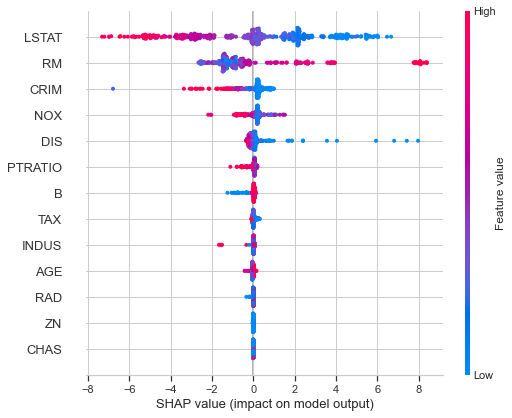

In [17]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [16]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48
